In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

from sklearn.feature_selection import SelectKBest, chi2
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = pd.read_csv('/Users/suchithkurra/Desktop/Honey_Pot Research/data/Web_attack.csv')

In [3]:
# Data preprocessing
# Drop any rows with missing values
data.dropna(inplace=True)

In [4]:
# Replace infinite or very large values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [5]:
# Drop rows containing NaN values
data.dropna(inplace=True)

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

In [7]:
# Split features and target variable
X = data.drop('Label', axis=1)
y = data['Label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# SelectKBest with ANOVA F-value
k = 20  # Number of top features to select
selector = SelectKBest(score_func=chi2, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

ValueError: Input X must be non-negative.

In [11]:
selected_features_indices = selector.get_support(indices=True)

AttributeError: 'SelectKBest' object has no attribute 'scores_'

In [12]:
selected_feature_names = X.columns[selected_features_indices]

In [13]:
# Print the selected feature names
print("Selected features:")
print(selected_feature_names)

Selected features:
Index(['Destination Port', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Fwd IAT Std', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'PSH Flag Count', 'ACK Flag Count', 'Down/Up Ratio',
       'Average Packet Size', ' Avg Fwd Segment Size', 'Avg Bwd Segment Size',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'min_seg_size_forward'],
      dtype='object')


In [14]:
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes model
nb_model =  MultinomialNB()
nb_model.fit(X_train_selected, y_train)

ValueError: Negative values in data passed to MultinomialNB (input X)

In [15]:
# Predictions
y_pred = nb_model.predict(X_test_selected)

In [16]:
# Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     33603
           1       0.30      0.98      0.45       444

    accuracy                           0.97     34047
   macro avg       0.65      0.98      0.72     34047
weighted avg       0.99      0.97      0.98     34047

Confusion Matrix:
[[32563  1040]
 [    8   436]]


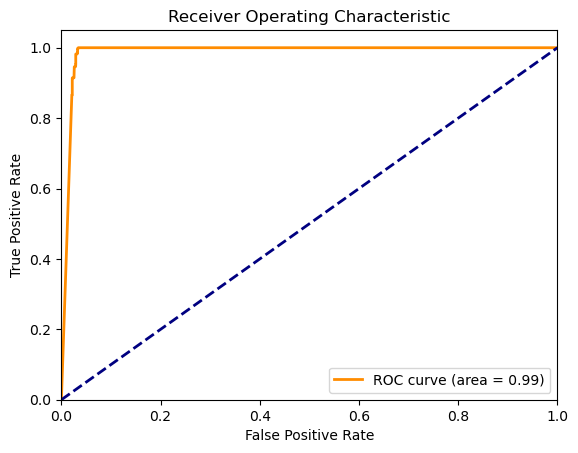

In [17]:
# Compute ROC curve
y_score = nb_model.predict_proba(X_test_selected)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

accuracy: 0.9692190207654126
precision: 0.2953929539295393
f1score: 0.45416666666666666


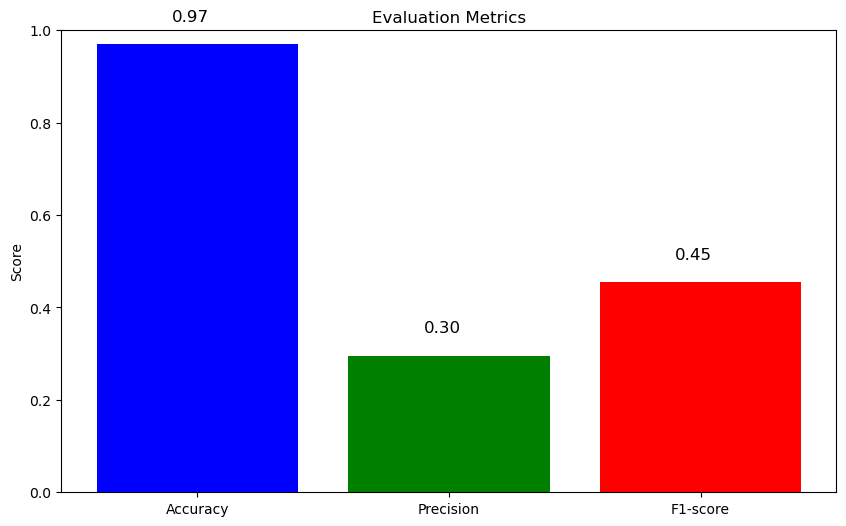

In [18]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Create grouped bar chart
metrics = ['Accuracy', 'Precision', 'F1-score']
values = [accuracy, precision, f1]

print('accuracy: ' + str(accuracy))
print('precision: ' + str(precision))
print('f1score: ' + str(f1))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)  # Setting y-axis limit to be between 0 and 1
plt.text(-0.1, accuracy + 0.05, f'{accuracy:.2f}', fontsize=12, color='black')
plt.text(0.9, precision + 0.05, f'{precision:.2f}', fontsize=12, color='black')
plt.text(1.9, f1 + 0.05, f'{f1:.2f}', fontsize=12, color='black')
plt.show()


Confusion Matrix:
[[32563  1040]
 [    8   436]]


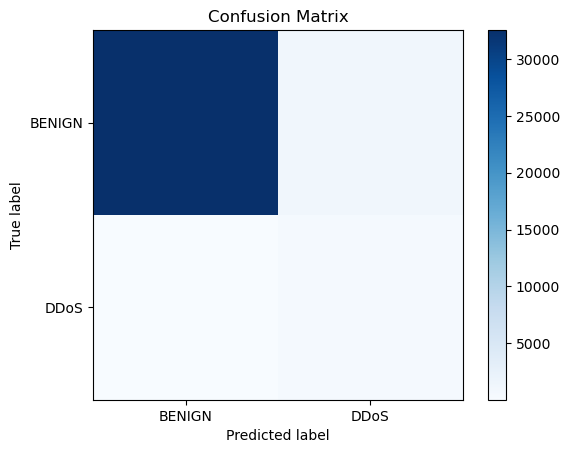

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1], ['BENIGN', 'DDoS'])
plt.yticks([0, 1], ['BENIGN', 'DDoS'])
plt.show()

In [20]:
# Extracting false positives and false negatives from confusion matrix
FP = conf_matrix[0, 1]  # False positives: predicted DDoS, actual BENIGN
FN = conf_matrix[1, 0]  # False negatives: predicted BENIGN, actual DDoS

print("False Positives:", FP)
print("False Negatives:", FN)

False Positives: 1040
False Negatives: 8


In [21]:
# Number of test values
num_test_values = len(y_test)
print("Number of test values:", num_test_values)

Number of test values: 34047


In [22]:
# Calculate percentage of false positives and false negatives
percentage = ((FP + FN) / num_test_values) * 100

print("Percentage of False Positives and False Negatives: {:.2f}%".format(percentage))


Percentage of False Positives and False Negatives: 3.08%


In [23]:
import joblib

# Save the trained model to a file
joblib.dump(nb_model, 'web_attack_nb_model.pkl')

# Load the model from file
# loaded_model = joblib.load('svm_model.pkl')

['web_attack_nb_model.pkl']